In [ ]:
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

In [ ]:
import os
from PIL import Image
from keras.preprocessing.image import img_to_array

In [ ]:
tumor = [('glioma_tumor', 0),('meningioma_tumor', 1),('no_tumor', 2),('pituitary_tumor', 3)]
path1 = '/input/brain-tumor-classification-mri/Training/'
path2 = '/input/brain-tumor-classification-mri/Testing/'

# Image Processing

In [ ]:
Path = [
    '../input/brain-tumor-classification-mri/Training/glioma_tumor/gg (104).jpg'  ,
    '../input/brain-tumor-classification-mri/Training/meningioma_tumor/m (10).jpg',
    '../input/brain-tumor-classification-mri/Training/no_tumor/image (12).jpg'    ,
    '../input/brain-tumor-classification-mri/Training/pituitary_tumor/p (122).jpg',
]

In [ ]:
def display (img_array) :
    
    dim = 10
    
    plt.figure(figsize  = (dim , dim))
    for i, img in enumerate(img_array) :
        plt.subplot(2, 2, i+1)
        plt.imshow(img,'gray')
        plt.title(img.shape)
        
    plt.show()

In [ ]:
def get_array (path) :
    
    X = []
    y = []
    
    for typ, val in tumor :
        for image in os.listdir(path+typ) :
            img = cv2.resize(cv2.imread(path+typ+'/'+image, cv2.IMREAD_GRAYSCALE), (200,200))
            
            # create arrays
            X.append(img_to_array( Image.fromarray(img)))
            y.append(val)
    return X, y

In [ ]:
image_array = []
for i, image_path in enumerate(Path) :
    image_array.append(cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), (200,200)))

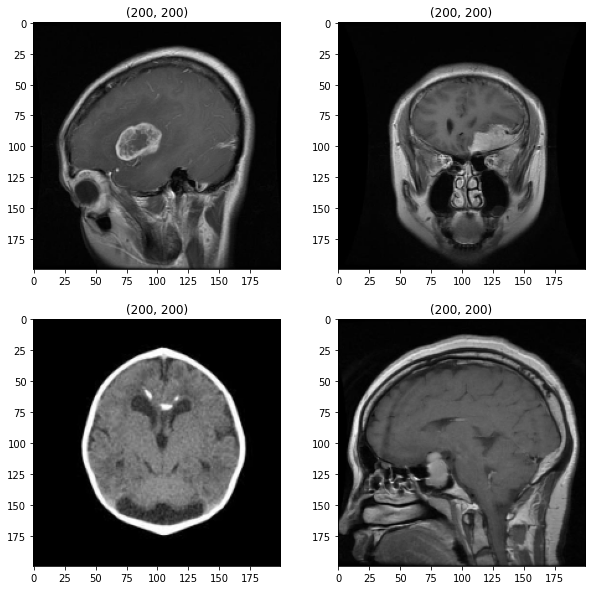

In [ ]:
display(image_array)

# Convert Images to Numpy arrays

In [ ]:
X_train, y_train = get_array(path1)

In [ ]:
X_test , y_test  = get_array(path2)

In [ ]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# Scale the arrays

In [ ]:
X_train = np.array(X_train)
X_train/= 255.0

In [ ]:
y_train = np.array(keras.utils.to_categorical(y_train))

In [ ]:
X_test = np.array(X_test)
X_test/= 255.0

In [ ]:
y_test = np.array(keras.utils.to_categorical(y_test))

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2870, 200, 200, 1)
(2870, 4)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(394, 200, 200, 1)
(394, 4)


In [ ]:
info = {0 : 'Glioma tumor', 1 : 'Meningioma tumor', 2 : 'No tumor', 3 : 'Pituitary tumor'}

# Plots of some training samples

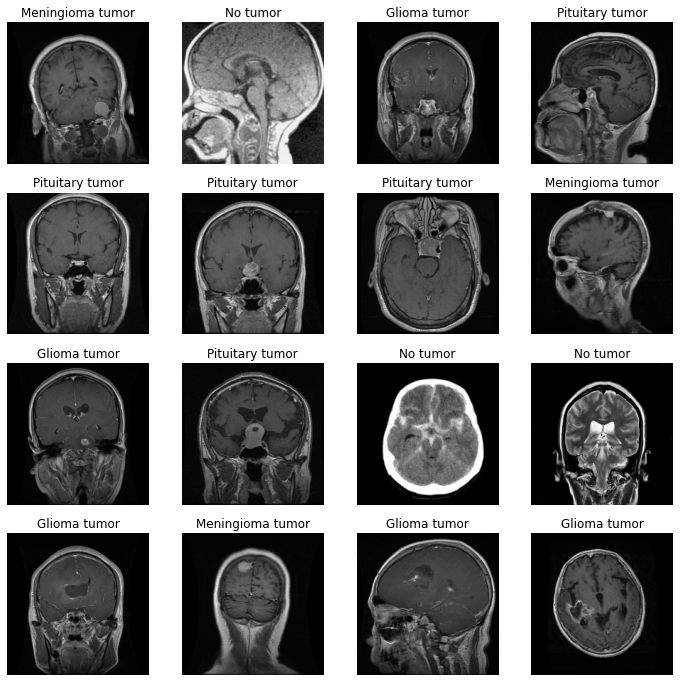

In [ ]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(0, 2870)
    plt.imshow(X_train[x], 'gray')
    plt.title(info[np.argmax(y_train[x])])
    plt.axis('off')
plt.show()

# Class frequency distribution

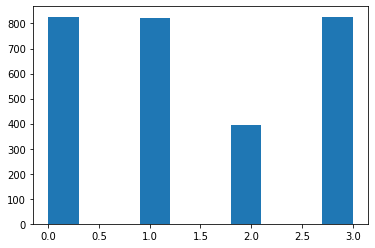

In [ ]:
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

# Synthetic Minority Oversampling
**Glioma tumor, Meningioma tumor** and **Pituitary tumor** almost same number of datasets ie. 826, 822 and 827 respectively. But the label **no_tumor** has only 395 samples. Since the number of samples for **no_tumor** class is less, let's oversample that class using SMOTE from imblearn package.

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2870, 200, 200, 1)
(2870, 4)


In [ ]:
X_train = np.reshape(X_train, (2870, 200*200*1))
print(X_train.shape)
print(y_train.shape)

(2870, 40000)
(2870, 4)


In [ ]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1, k_neighbors = 5).fit_resample(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [ ]:
print(X_train.shape)
print(y_train.shape)

(3308, 40000)
(3308, 4)


In [ ]:
X_train = np.reshape(X_train, (3308, 200, 200, 1))
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308, 4)


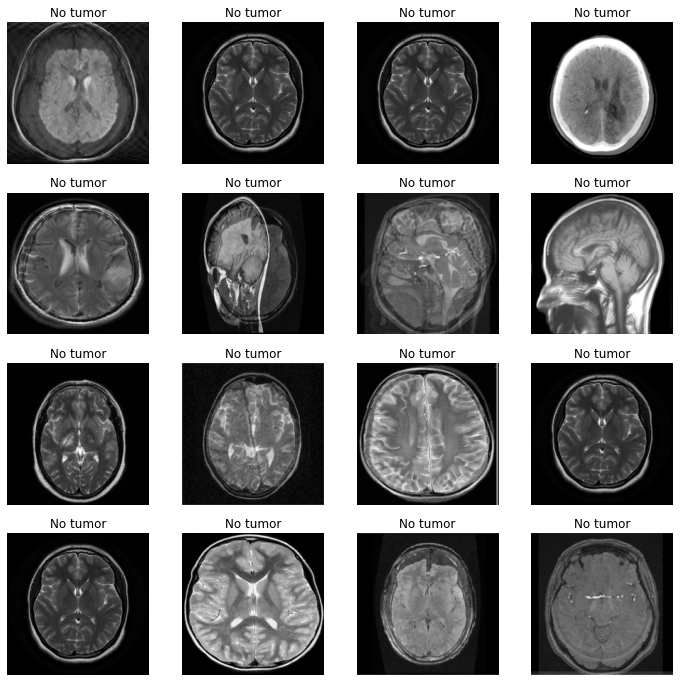

In [ ]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(2870, 3308)
    plt.imshow(X_train[x], 'gray')
    plt.title(info[np.argmax(y_train[x])])
    plt.axis('off')
plt.show()

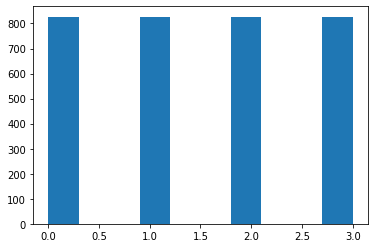

In [ ]:
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

# Images of test samples

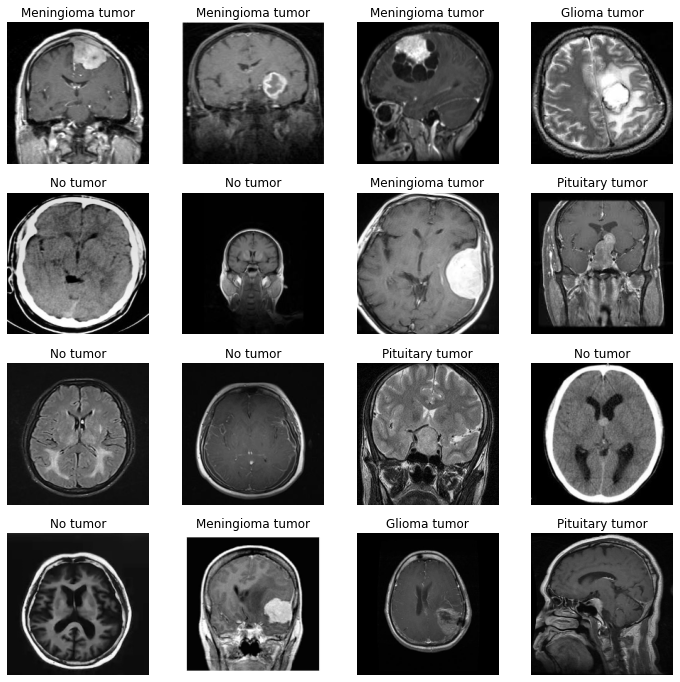

In [ ]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(0,390)
    plt.imshow(X_test[x],'gray')
    plt.title(info[np.argmax(y_test[x])])
    plt.axis('off')
plt.show()

# Model creation and training

In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Conv2D

In [ ]:
def conv_layer (filterx) :
    
    model = Sequential()
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid'))
    model.add(BatchNormalization())
    
    return model

In [ ]:
def dens_layer (hiddenx) :
    
    model = Sequential()
    model.add(Dense(hiddenx, activation = 'relu', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [ ]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    
    model.add(Input((200,200,1,)))
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    model.add(Dense(4, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])
    
    return model

# Use ImageDataGenerator for image data augmentation

In [ ]:
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308, 4)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(zoom_range = [0.85, 1.0], rotation_range = 3)

In [ ]:
gen.fit(X_train)
train_gen = gen.flow(X_train, y_train, batch_size = 32)

In [ ]:
trainX, trainy = train_gen.next()

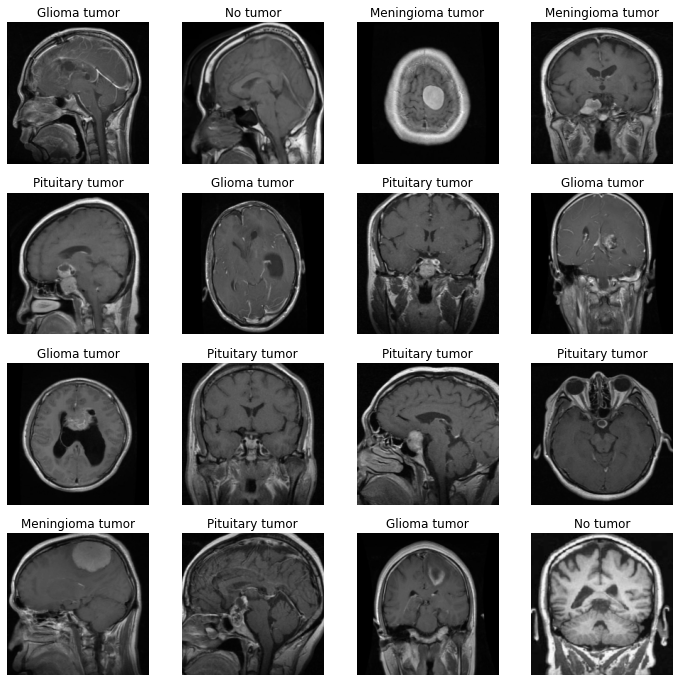

In [ ]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    plt.imshow(trainX[i], 'gray')
    plt.title(info[np.argmax(trainy[i])])
    plt.axis('off')
plt.show()

## Model implementation

In [ ]:
from keras.callbacks import ModelCheckpoint
checkp = ModelCheckpoint('./brain_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)

In [ ]:
model = cnn(128, 64, 32, 128, 64)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 100, 100, 128)     1792      
_________________________________________________________________
sequential_2 (Sequential)    (None, 50, 50, 64)        74048     
_________________________________________________________________
sequential_3 (Sequential)    (None, 25, 25, 32)        18592     
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 128)               2560640   
_________________________________________________________________
sequential_5 (Sequential)    (None, 64)                8512      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [ ]:
history = model.fit(gen.flow(X_train, y_train, batch_size = 32), epochs = 100, validation_data = (X_test,y_test), callbacks = [checkp])

Epoch 1/100
104/104 [==============================] - 31s 266ms/step - loss: 4.6014 - accuracy: 0.5586 - val_loss: 5.5782 - val_accuracy: 0.1878

Epoch 00001: val_accuracy improved from -inf to 0.18782, saving model to ./brain_model.h5
Epoch 2/100
104/104 [==============================] - 26s 250ms/step - loss: 3.9795 - accuracy: 0.7208 - val_loss: 6.3239 - val_accuracy: 0.2665

Epoch 00002: val_accuracy improved from 0.18782 to 0.26650, saving model to ./brain_model.h5
Epoch 3/100
104/104 [==============================] - 26s 250ms/step - loss: 3.6484 - accuracy: 0.8178 - val_loss: 6.4942 - val_accuracy: 0.2665

Epoch 00003: val_accuracy did not improve from 0.26650
Epoch 4/100
104/104 [==============================] - 26s 250ms/step - loss: 3.4573 - accuracy: 0.8287 - val_loss: 5.4917 - val_accuracy: 0.3909

Epoch 00004: val_accuracy improved from 0.26650 to 0.39086, saving model to ./brain_model.h5
Epoch 5/100
104/104 [==============================] - 26s 250ms/step - loss: 3.2

Text(0.5, 1.0, 'Loss vs Epochs')

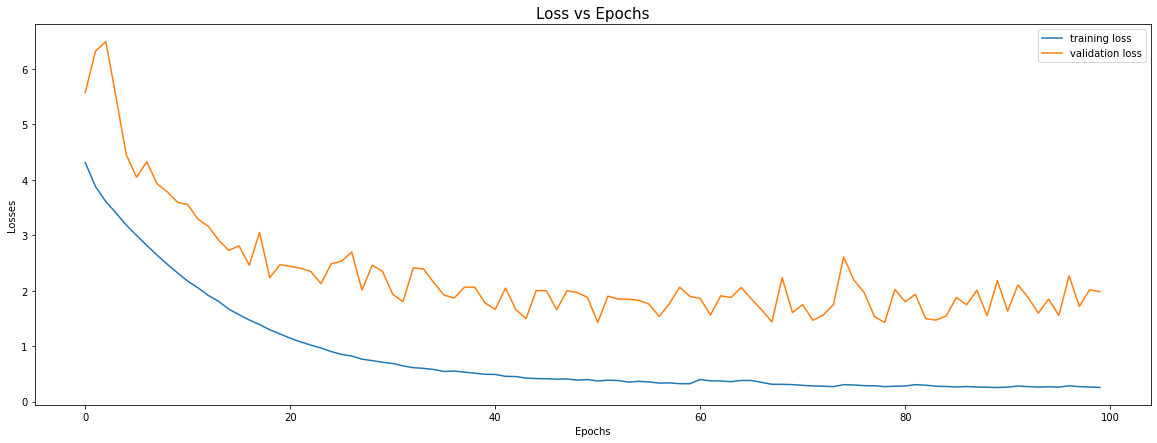

In [ ]:
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss vs Epochs', fontsize = 15)

Text(0.5, 1.0, 'Accuracy vs Epochs')

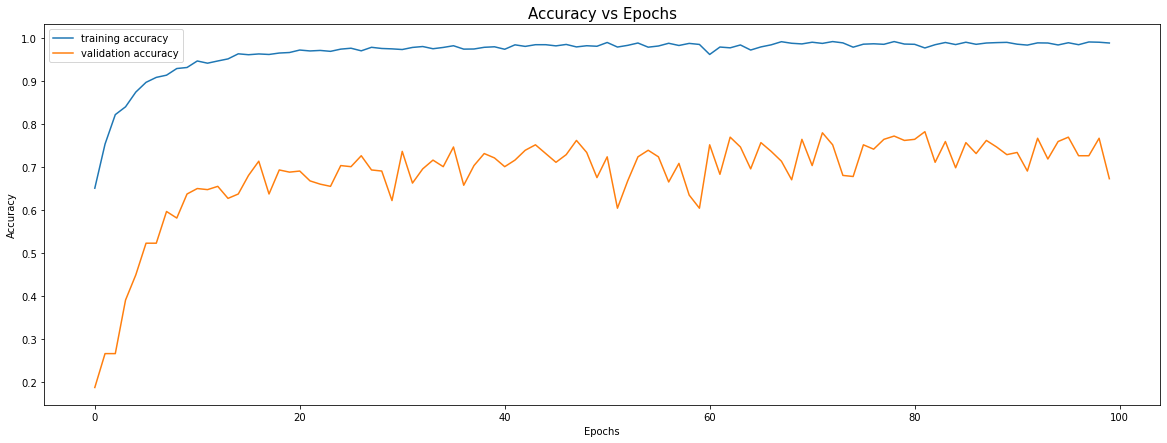

In [ ]:
plt.figure(figsize = (20,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs', fontsize = 15)

# Prediction

In [ ]:
from keras.models import load_model
model = load_model('./brain_model.h5')

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(pred[0:3,:])

[[3.2259148e-04 1.0492647e-03 9.9862552e-01 2.6121390e-06]
 [1.4105506e-03 3.3774856e-01 3.5074386e-01 3.1009704e-01]
 [7.4510007e-07 9.9986708e-01 1.2537984e-04 6.8493955e-06]]


In [ ]:
temp = np.argmax(pred, axis = 1)
pred = np.zeros(pred.shape)

In [ ]:
pred[np.arange(pred.shape[0]), temp] = 1

In [ ]:
print(pred[0:3,:])
print(y_test[0:3,:])

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy : ' + str(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred, target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))

Accuracy : 0.7817258883248731
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.26      0.41       100
meningioma_tumor       0.74      0.96      0.83       115
        no_tumor       0.70      0.97      0.82       105
 pituitary_tumor       0.96      0.95      0.95        74

       micro avg       0.78      0.78      0.78       394
       macro avg       0.84      0.78      0.75       394
    weighted avg       0.83      0.78      0.74       394
     samples avg       0.78      0.78      0.78       394

